## 1. Постановка задачи


В данном проекте решается бизнес-задача в области маркетинга. Необходимо произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать модель на новых клиентах.

## 2. Знакомство с данными. 

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 
import re

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
# Загружаем данные
data = pd.read_csv("../data/customer_segmentation_project.csv",
                   encoding="ISO-8859-1",
                   dtype={'CustomerID': str, 'InvoiceID': str}
                   )
# Выводим размер датасета и первые 5 строк для проверки данных
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [3]:
# Делаем проверку соответствия типа данных в признаках и получаем количество 
# признаков, прошедших проверку, суммированием значений (True - 1, False - 0)
print(f"В данных {((data.dtypes=='float64') | (data.dtypes=='int64')).sum()}"
      f" столбца, кодируемых числовыми типами (int/float)"
      )

В данных 2 столбца, кодируемых числовыми типами (int/float)


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country 

In [4]:
# Посчитаем суммарное количество пропусков в каждом признаке, затем фильтруем Series 
# с помощью лямбда функции, оставляя только те признаки у которых число провусков 
# больше нуля и выводим названия этих признаков в виде списка
print(data.isnull().sum().loc[ lambda x : x != 0].index.to_list())

['Description', 'CustomerID']


### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09


In [5]:
# Преобразуем признак даты в формат datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Выводим самую раннюю и самую последнюю дату в данных
print(f"В данных представленны сведения за период с {data['InvoiceDate'].min().date()}" 
      f" по {data['InvoiceDate'].max().date()}")

В данных представленны сведения за период с 2010-12-01 по 2011-12-09


### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [6]:
# Выводим основные статистики по данным
display(data.describe())

# Выводим максимальное и минимальное количество товаров в заказе
print(f"Максимальное число товаров в заказе: {round(data['Quantity'].max())}")
print(f"Минимальное число заказов в товаре: {round(data['Quantity'].min())}")

# Создаем маску для фильтрации по признаку цены на условие, что цена неотрицательная
mask_price = data['UnitPrice'] >= 0

# Выводим минимальную цену товара
print(f"Самый дешевый товар стоит {data[mask_price]['UnitPrice'].min()} фунтов стерлингов")

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


Максимальное число товаров в заказе: 80995
Минимальное число заказов в товаре: -80995
Самый дешевый товар стоит 0.0 фунтов стерлингов


### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [7]:
# Определяем количество уникальных клиентов в данных
print(f"Количество уникальных клиентов в данных: {data['CustomerID'].nunique()}")

# Создаем маску для фильтрации данных по названию страны, исключая неопределенную страну
mask_country = data['Country'] != 'Unspecified'

# Определяем количество уникальных стран в данных
print(f"Количество уникальных стран в данных: {data[mask_country]['Country'].nunique()}")

# Выводим идентификатор самого популярного товара
print(f"Идентификатор самого популярного товара: {data['StockCode'].value_counts().iloc[:1].index[0]}")

Количество уникальных клиентов в данных: 4372
Количество уникальных стран в данных: 37
Идентификатор самого популярного товара: 85123A


### *Выводы*
В данных есть транзакции с количеством единиц товара 80995 и минус 80995. Можно предположить, что здесь речь об отмене транзакции. Кроме того есть товары с нулевой стоимостью. Стоит провести дополнительную проверку таких наблюдений.

## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков. 

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



In [8]:
# Считаем общее количество пропусков в таблице
print(f"В таблице {data.isna().sum().sum()} пропущенных значений")

# Удаляем строки с пропусками
data.dropna(inplace=True)

# Выводим получившееся в таблице количество строк
print(f'Количество строк в таблице после удаления пропусков: {data.shape[0]}')

В таблице 136534 пропущенных значений
Количество строк в таблице после удаления пропусков: 406829


### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [9]:
# Считаем суммарное количество дубликатов в таблице
print(f'В таблице {data.duplicated().sum()} дубликатов')

# Удаляем дубликаты и выводим количество строк в таблице
data.drop_duplicates(inplace=True)
print(f'Количество строк в таблице после удаления дубликатов: {data.shape[0]}')

В таблице 5225 дубликатов
Количество строк в таблице после удаления дубликатов: 401604


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [10]:
# Создаем новый датасет содержащий транзакции с отрицательным количеством товара
negative_quantity = data[(data['Quantity']<0)]

# Выводим количество таких транзакций
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))

# Выводим первые 5 строк нового датасета
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Итак, таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

+ Номер заказа (InvoiceNo) и код товара (StockCode) могут содержать не только числа, но и символы.                         
+ Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами  клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.                       
+ Код товара может содержать различные специальные символы: например, символ "D", судя по описанию товара (столбец Description), означает наличие скидки.                   
+ Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).                  

Примечание. При анализе таблицы вы могли заметить, что отрицательное количество товаров может не сопровождаться признаком возврата (символ "C" перед номером заказа отсутствует). Таких транзакций 1336 штук, и для всех них не указан идентификатор пользователя (CustomerID). Мы удалили эти транзакции, когда удаляли строки таблицы, в которых пропущен идентификатор пользователя.

### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [11]:
# Создаем признак отмены заказа проверяя наличие ключа "С" в значении номера заказа среди заказов 
# с отрицательным значением товара
negative_quantity['cancel'] = negative_quantity['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)

# Выводим количество транзакций не являющихся возвратом, но содержих отрицательное количество товара
print(f"Количество транзакций не являющихся возвратом, но содержих отрицательное количество товара: "
      f"{negative_quantity[negative_quantity['cancel']==0].shape[0]}")
print('Все транзакции с отрицательным количеством товара являются возвратами.')

Количество транзакций не являющихся возвратом, но содержих отрицательное количество товара: 0
Все транзакции с отрицательным количеством товара являются возвратами.


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


***Примечание:*** Под уникальностью товара тут имеется в виду не количество уникальных товаров во всем первоначальном датасете, а количество уникальных товаров для конкретного заказа конкретного пользователя. В первоначальном датасете каждому такому уникальному товару соответствовала одна строка, поэтому, чтобы получить их количество нужно сгруппировать датасет по клиенту и номеру заказа и посчитать количество строк для такого соответствия. 



In [12]:
# Строим вспомагательную таблицу nb_products_per_basket сгруппировав данные 
# по ID клиента и номеру заказа и подсчитав количество уникальных товаров для 
# конкретного заказа конкретного пользователя
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

# Переименовываем столбец с количеством уникальных товаров для конкретного заказа 
# конкретного пользователя и выводим первые 5 строк
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [13]:
# Создаем новый признак отмены заказа
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)

# Выводим процент возвра заказов
print(f"{round(nb_products_per_basket['order_canceled'].value_counts(normalize=True).iloc[1]*100)}"
      f"% транзакций являются возвратами"
      )

16% транзакций являются возвратами


Давайте поближе взглянем на отмененные заказы:


In [14]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [15]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций. 

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна
* Нет, не верна



In [16]:
# Создаем копию таблицы с отрицательным количеством товаров в заказе
canceled = negative_quantity.copy()

# Меняем знак в признаке количества товаров, чтобы можно было провести сравнение
canceled['Quantity'] = -1*canceled['Quantity']

# Сбрасываем значение индексов
canceled.reset_index(inplace=True)

# Добавляем в таблицу canceled строки из таблицы data совпадающие по коду товара, 
# идентификатору клиента и противоположному значению количества товара
merged = pd.merge(canceled,
                  data,
                  how='inner',
                  on=['StockCode', 'CustomerID', 'Quantity']
                  )

# Исключив дубоикаты из полученной таблицы найдем количество возвратов 
# для которых нашлась пара
merged.drop_duplicates(subset='index', inplace=True)

# Вычитая количество строк таблицы из количества строк таблицы получим количество 
# отмененных товаров, для которых нет пары
print(f"Количество отмененных товаров, для которых нет пары: "
      f"{negative_quantity.shape[0] - merged.shape[0]}"
      )

Количество отмененных товаров, для которых нет пары: 5626


Гипотеза не подтвердилась: не все заказы с отрицательным количеством товара имеют в таблице свои аналоги. Нужно дальше разбираться, почему так происходит.

Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [17]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна 


In [18]:
# Создаем копию таблицы с отрицательным количеством товаров в заказе
canceled_no_D = negative_quantity[negative_quantity['StockCode']!='D']

# Меняем знак в признаке количества товаров, чтобы можно было провести сравнение
canceled_no_D['Quantity'] = -1*canceled_no_D['Quantity']

# Сбрасываем значение индексов
canceled_no_D.reset_index(inplace=True)

# Добавляем в таблицу canceled строки из таблицы data совпадающие по коду товара, 
# идентификатору клиента и противоположному значению количества товара
merged = pd.merge(canceled_no_D,
                  data,
                  how='inner',
                  on=['StockCode', 'CustomerID', 'Quantity']
                  )

# Исключив дубоикаты из полученной таблицы найдем количество возвратов 
# для которых нашлась пара
merged.drop_duplicates(subset='index', inplace=True)

# Вычитая количество строк таблицы из количества строк таблицы получим количество 
# отмененных товаров, для которых нет пары
print(f"Количество отмененных товаров, для которых нет пары: "
      f"{canceled_no_D.shape[0] - merged.shape[0]}"
      )

Количество отмененных товаров, для которых нет пары: 5549


Эта гипотеза тоже не подтвердилась. Даже исключив товары со скидками, мы не можем найти аналогов для некоторых отменённых заказов.

Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [19]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Используем заготовленную функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [20]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
data['QuantityCanceled'] = quantity_canceled

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [21]:
# Выводим суммарное количество отмененных товаров 
print(f'Cуммарное количество отмененных товаров в столбце QuantityCanceled: {quantity_canceled.sum()}')

Cуммарное количество отмененных товаров в столбце QuantityCanceled: 245266.0


## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [22]:
# Создаем новую таблицу фильтрую исходную таблицу по признаку количества товара больше нуля
data = data[data['Quantity'] > 0]
print(f"Количество транзакций без учета возвратов: " 
      f"{data.shape[0]}"
      )

Количество транзакций без учета возвратов: 392732


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [23]:
# Создаем вспомагательный признак наличия букв коде товара,  символ ^ вне квадратных скобок 
# означает начало строки, в скобках указано какие символы ищем, плюс в конце - говорит, 
# что количество символов может быть любым
data['letterscode'] = data['StockCode'].str.contains(pat=r'^[a-zA-Z]+', regex=True)

# Выводим количество уникальных кодов товара, содержащих буквы
data[data['letterscode']]['StockCode'].nunique()

# Убираем из таблицы все строки где код товара содержит буквы
data = data[~data['letterscode']]

# Убираем вспомагательный признак и выводим количество оставшихся строк
data = data.drop('letterscode', axis=1)
print(f'Количество записей в таблице: {data.shape[0]}')

Количество записей в таблице: 391183


### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?



In [24]:
# Выводим количество транзакций для которых цена равна 0 фунтов стерлингов
print(f"Транзакций с нулевой ценой: {data[data['UnitPrice']==0].shape[0]}")

# Избавляемся от этих записей
data = data[data['UnitPrice']!=0]

# Выводим оставшееся количество строк
print(f'Итоговое количество строк в данных: {data.shape[0]}')

# Запишем данны в файл
data.to_csv('../data/Project_6_data.csv',index=False)

Транзакций с нулевой ценой: 33
Итоговое количество строк в данных: 391150


Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


Наибольшее количество клиентов живет в United Kingdom


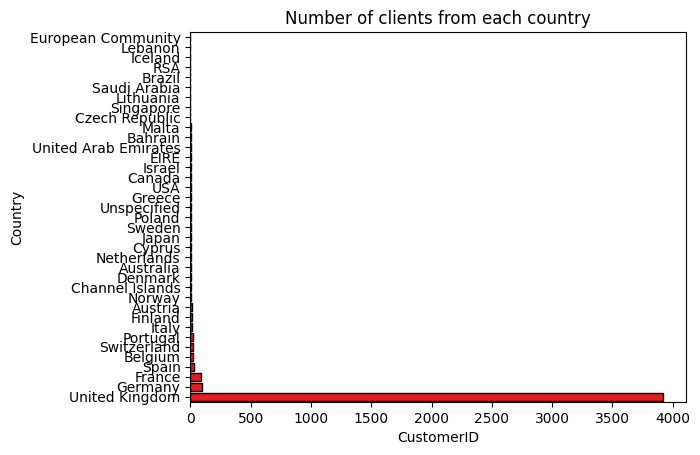

In [25]:
# Загружаем сохраненные ранее данные и проверяем их
data = pd.read_csv('../data/Project_6_data.csv')
display(data.head())

# Cоздаем таблицу сгрупировав по странам количество уникальных идентификаторов клиентов и сортируем её по возрастанию
table = data.groupby(['Country'], as_index=False)['CustomerID'].nunique().sort_values(by='CustomerID')

# Строим столбчатую диаграмму
fig = sns.barplot(data=table, x='CustomerID', y='Country', color='red')
fig.set_title('Number of clients from each country');

# Выводим результат
print(f"Наибольшее количество клиентов живет в "
      f"{table['Country'].iloc[-1:].item()}")

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


Топ-3 строн по количеству заказов:
            Country  InvoiceNo
13          France       8019
14         Germany       8643
35  United Kingdom     348872


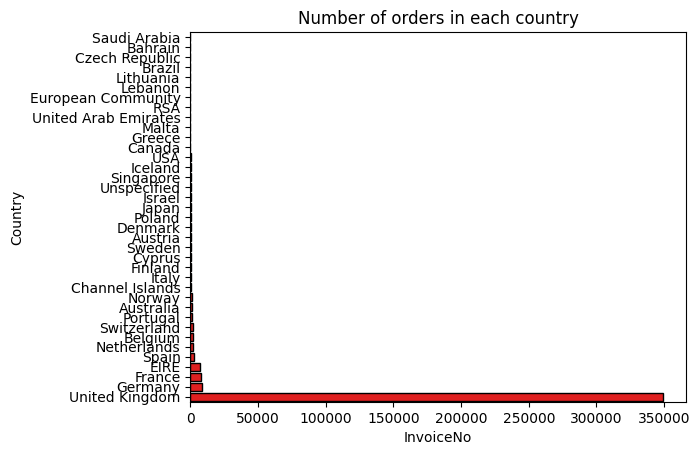

In [89]:
# Cоздаем таблицу сгрупировав по странам количество заказов и сортируем её по возрастанию
table = data.groupby(['Country'], as_index=False)['InvoiceNo'].count().sort_values(by='InvoiceNo')

# Строим столбчатую диаграмму
fig = sns.barplot(data=table, x='InvoiceNo', y='Country', color='red')
fig.set_title('Number of orders in each country')

# Выводим топ-3 строн по количеству заказов
print(f"Топ-3 строн по количеству заказов:\n {table.iloc[-3:]}")

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [27]:
# Создаем новый признак общей стоимости заказа
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

# Выводим среднее значение общей стоимости заказа
print(f"Средняя общая стоимость заказов составляет: {round(data['TotalPrice'].mean())} £")

Средняя общая стоимость заказов составляет: 21 £


### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


Топ-3 строн, клиенты из которых приносят компании больше всего выручки:            Country  TotalPrice
10            EIRE   247074.57
23     Netherlands   283443.54
35  United Kingdom  6797691.44


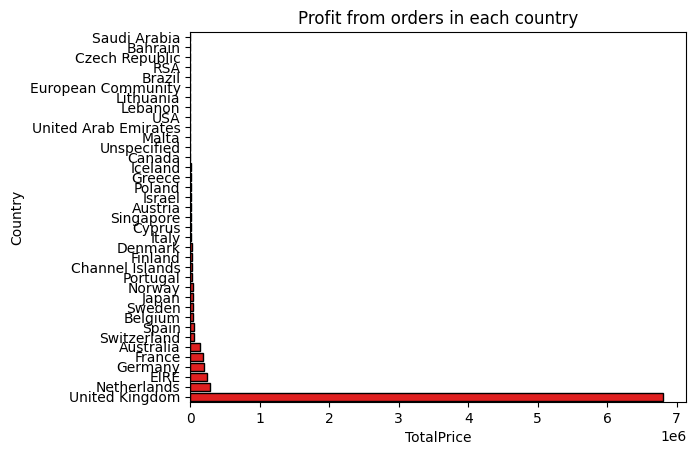

In [90]:
# Cоздаем таблицу сгрупировав по странам общую стоимость заказов и сортируем её по возрастанию
table = data.groupby(['Country'], as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice')

# Строим столбчатую диаграмму
fig = sns.barplot(data=table, x='TotalPrice', y='Country', color='red')
fig.set_title('Profit from orders in each country');

# Выводим топ-3 строн по количеству заказов, клиенты из которых приносят компании больше всего выручки
print(f"Топ-3 строн, клиенты из которых приносят компании больше всего выручки:"
      f" {table.iloc[-3:]}"
      )

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

Самый прибыльный месяц: 11


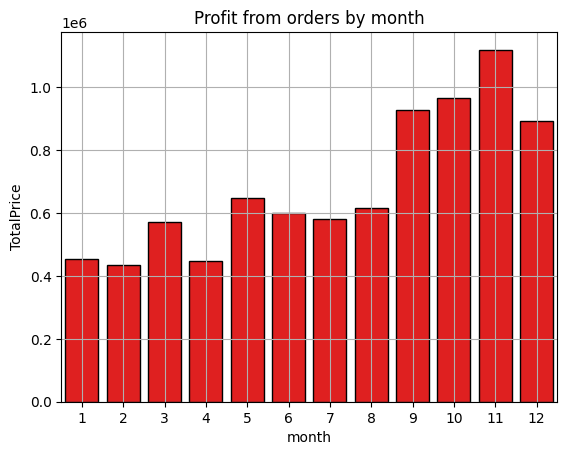

In [91]:
# Преобразуем даты в формат datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Создаем новые признаки месяца, дня недели и часа совершения заказа
data['month'] = data['InvoiceDate'].dt.month
data['day_of_weak'] = data['InvoiceDate'].dt.day_name()
data['hour'] = data['InvoiceDate'].dt.hour

# создаем таблицу сгрупировав по месяцам общую стоимость заказов
table = data.groupby(['month'], as_index=False)['TotalPrice'].sum()

# Строим столбчатую диаграмму
fig = sns.barplot(data=table, y='TotalPrice', x='month', color='red', orient='v')
fig.set_title('Profit from orders by month')
fig.grid()

# Выводим самый прибыльный месяц
print(f"Самый прибыльный месяц: {round(table.sort_values(by='TotalPrice').iloc[-1]['month'])}")

### *Вывод*
Самый прибыльный месяц для компании по продаже подарков это ноябрь. Это объясняется тем, что в ноябре проходит так называемая чёрная пятница (англ. Black Friday) — пятница после Дня благодарения в США. С неё начинается традиционный рождественский сезон распродаж. Обычай устраивать распродажи в этот день установился ещё в XIX веке, а термин «чёрная пятница» появился в 1966 году и поначалу употреблялся в основном на Восточном побережье США. Из-за того, что День благодарения приходится на четвёртый четверг ноября, чёрная пятница выпадает в промежуток времени с 23 по 29 ноября.

### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота 
* Воскресенье


День недели в который не было ни одного заказа: Saturday


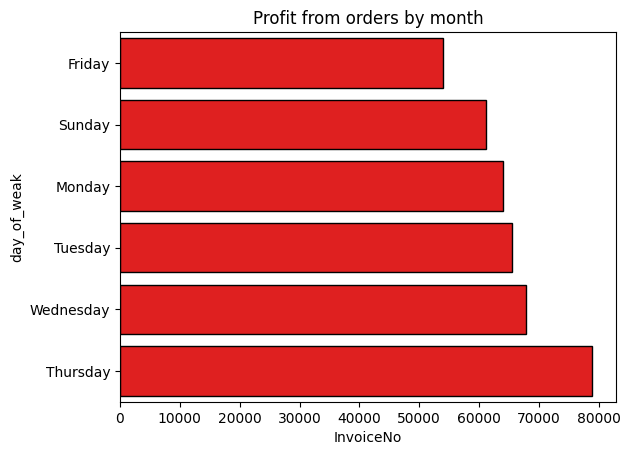

In [92]:
# создаем таблицу сгрупировав по дням недели количество заказов
table = data.groupby(['day_of_weak'], as_index=False)['InvoiceNo'].count().sort_values(by='InvoiceNo')

# Строим столбчатую диаграмму
fig = sns.barplot(data=table, x='InvoiceNo', y='day_of_weak', color='red')
fig.set_title('Profit from orders by month')

# Задаем множество с названиями дней недлели и вычитаем из него уникальные дни недели из наших данных
name_day_of_weak = set(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print(f"День недели в который не было ни одного заказа: {list(name_day_of_weak - set(table['day_of_weak'].unique()))[0]}")

### *Вывод*
Отстутствие транзакций в субботу может объясняться тем, что суббота является выходным днём и транзакции в этот день не совершаются. Но возможно это ошибка в данных.


### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


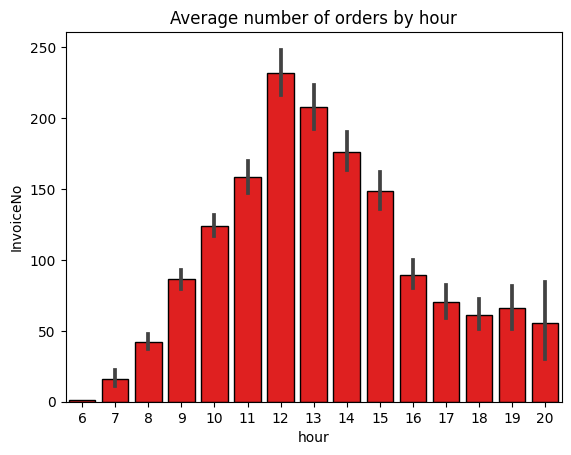

In [34]:
# Выделяем дату из признака времени совершения транзакции
data['date'] = data['InvoiceDate'].dt.date

# создаем таблицу сгрупировав по датам и часам количество заказов
table = data.groupby(['date', 'hour'], as_index=False)['InvoiceNo'].count()

# Строим столбчатую диаграмму
fig = sns.barplot(data=table, y='InvoiceNo', x='hour', color='red')
fig.set_title('Average number of orders by hour');

### *Выводы*
Как видно на столбчатой диаграмме:
* больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов;
* начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают. 

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [111]:
# Группируем данные по клиентам, считая требуемую агрегацию по определенным столбцам
rfm_table = data.groupby(by='CustomerID').agg({'InvoiceDate':['max'],
                                               'InvoiceNo':['nunique'],
                                               'TotalPrice':['sum']
                                               }
                                              )

# Задаем точку отсчета в формате datetime
t_0 = pd.to_datetime('2011-12-10 00:00:00')

# Вычитаем из точки отсчета дату последней совершенной покупки и переводим в дни
rfm_table['InvoiceDate', 'max'] = rfm_table['InvoiceDate', 'max'].apply(lambda x: t_0-x).dt.days

# Переименовываем столбцы таблицы
rfm_table = rfm_table.rename(columns={'InvoiceDate':'Recency',
                                      'InvoiceNo':'Frequency',
                                      'TotalPrice':'Monetary Value'
                                      }
                             )

# Удалим лишний уровень в наименовании колонок с названиями агрегирующих функций
rfm_table.columns = rfm_table.columns.droplevel(1)

# Проверяем результат
display(rfm_table.head())

,Recency,Frequency,Monetary Value
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [112]:
# Выводим информацию по заданным вопросам
print(f"{rfm_table[rfm_table['Recency'] > 200].shape[0]} клиентов совершили покупку более 200 дней назад")
print(f"В среднем клиент делает {round(rfm_table['Frequency'].mean())} заказов")
print(f"Клиент с ID 12360 потратил {round(rfm_table.loc[12360, 'Monetary Value'])} £")

743 клиентов совершили покупку более 200 дней назад
В среднем клиент делает 4 заказов
Клиент с ID 12360 потратил 2302 £


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [113]:
# Строим коробчатые диаграммы
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):    
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('../pic/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у вас остались в RFM-таблице?


In [114]:
# Создаем переменные хранящие значение квантили уровня 0.95 для интересующих нас признаков
q_95_frequency = rfm_table['Frequency'].quantile(0.95)
q_95_monetary = rfm_table['Monetary Value'].quantile(0.95)

# Создаем очищенную таблицу используя фильтр по значениям и выводим количество оставшихся записей
rfm_table_cleaned = rfm_table[(rfm_table['Frequency'] <= q_95_frequency )&(rfm_table['Monetary Value'] <= q_95_monetary)]
print(f'В rfm таблице осталось {rfm_table_cleaned.shape[0]} записей')

В rfm таблице осталось 4044 записей


После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [115]:
# Посмотрим на изменения коробчатых диаграмм
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('../pic/boxplot_2.html')
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


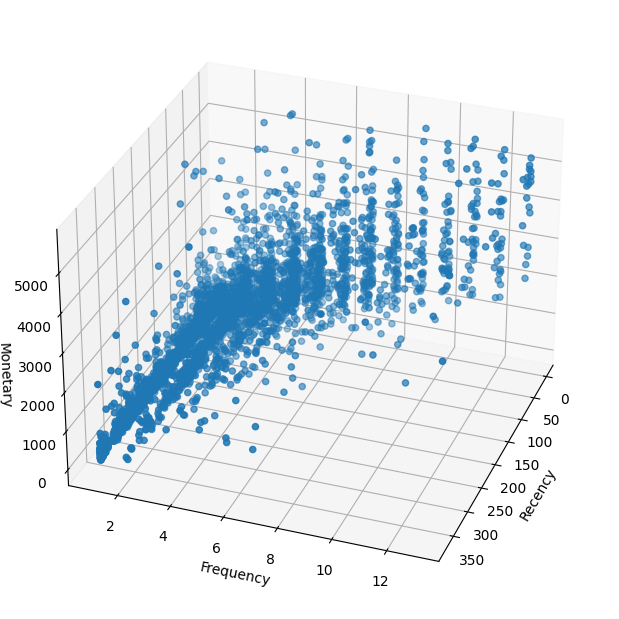

In [116]:
# Cоздадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# Добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# Визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary Value'].to_list()
)

# Добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [117]:
# Создаем пайплайн с необходимыми преобразователями
p_line = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                     ('pca', decomposition.PCA(n_components=2))
                     ]
                    )

# Обучаем пайплайн на очищенных данных
p_line.fit(rfm_table_cleaned)

# Применяем к таблице обученный пайплайн
rfm_table_processed = p_line.transform(rfm_table_cleaned)

# Выводим долю дисперсии объяснеямой первой компонентой 
print(f"Первая главная компонента объясняет долю дисперсии, равную:" 
      f" {round(p_line['pca'].explained_variance_ratio_[0], 2)}")

Первая главная компонента объясняет долю дисперсии, равную: 0.68


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

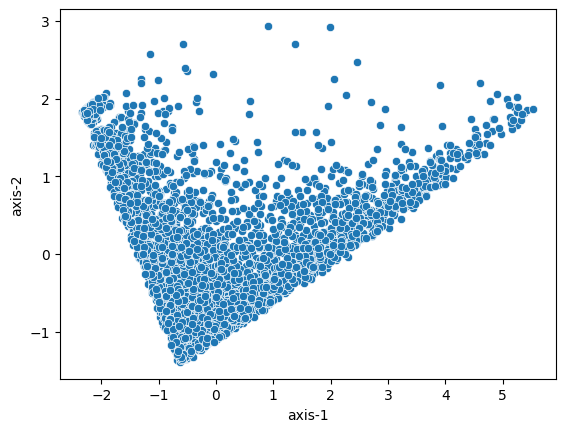

In [118]:
# Преобразуем таблицу обратно в датафрейм
rfm_table_processed = pd.DataFrame(rfm_table_processed,
                                   columns=['axis-1', 'axis-2'],
                                   index=rfm_table_cleaned.index)

# Визуализируем данные
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

### Задание 5.4
Попробуем воспользоваться методом k-means. 

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


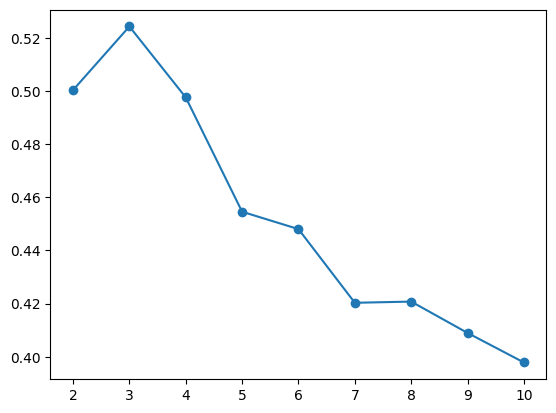

Оптимальное количество кластеров по коэффициенту силуэта: 3
Максимальное значение коэффициента силуэта равно: 0.52


In [119]:
# Создаем список для фиксации значений коэффициента силуэта
silhouette = []

# В цмкле перебираем значения количества кластеров, обучаем модель и 
# заносим в список полученное значение коэффициента силуэта
for clust_num in range(2, 11):
    k_means = cluster.KMeans(n_clusters=clust_num, random_state=42)
    k_means.fit(rfm_table_processed)
    silhouette.append(metrics.silhouette_score(rfm_table_processed, k_means.labels_))

# Визуализируем результат
plt.plot([i for i in range(2, 11)], silhouette, marker='o')
plt.show()

# Выводим оптимальное число кластеров и максимальное значение коэффициента силуэта
print(f'Оптимальное количество кластеров по коэффициенту силуэта: '
      f'{[i for i in range(2, 11)][silhouette.index(max(silhouette))]}')
print(f'Максимальное значение коэффициента силуэта равно: {round(max(silhouette), 2)}')

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


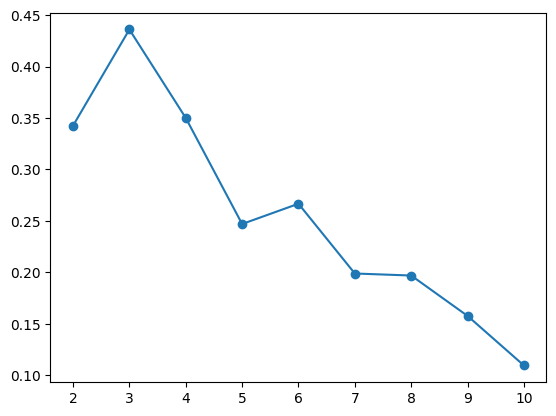

Оптимальное количество кластеров по коэффициенту силуэта: 3
Максимальное значение коэффициента силуэта равно: 0.44


In [120]:
# Создаем список для фиксации значений коэффициента силуэта
silhouette_em = []

# В цмкле перебираем значения количества кластеров, обучаем модель и 
# заносим в список полученное значение коэффициента силуэта
for clust_num in range(2, 11):
    em = mixture.GaussianMixture(n_components=clust_num, random_state=42)
    em.fit(rfm_table_processed)
    silhouette_em.append(metrics.silhouette_score(rfm_table_processed, em.predict(rfm_table_processed)))

# Визуализируем результат
plt.plot([i for i in range(2, 11)], silhouette_em, marker='o')
plt.show()

# Выводим оптимальное число кластеров и максимальное значение коэффициента силуэта
print(f'Оптимальное количество кластеров по коэффициенту силуэта: '
      f'{[i for i in range(2, 11)][silhouette_em.index(max(silhouette_em))]}')
print(f'Максимальное значение коэффициента силуэта равно: {round(max(silhouette_em), 2)}')

### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [121]:
# Наибольшее значение коэффициента силуэта у модели K-Means на 3 кластерах 
# используем её для кластеризации
k_means = cluster.KMeans(n_clusters=3, random_state=42)

# Обучаем модель
k_means.fit(rfm_table_processed)

# Создаем признак с номером кластера
rfm_table_processed['labels'] = k_means.labels_

print(f"Количество клиентов в самом большом кластере: {rfm_table_processed['labels'].value_counts().max()}")


Количество клиентов в самом большом кластере: 2269


Визуализируем результаты кластеризации:

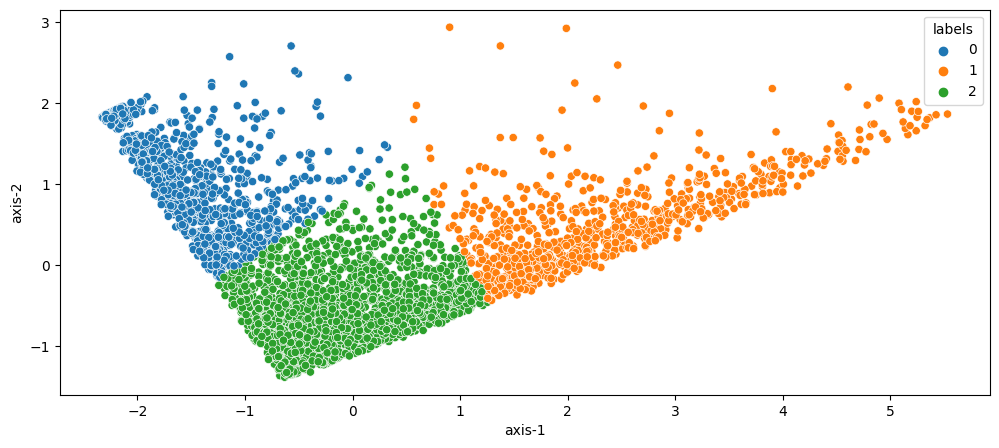

In [122]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue='labels',
    palette="tab10"
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [124]:
# Добавляем в rfm таблицу признак с метками кластеров
rfm_table_cleaned['labels'] = k_means.labels_

# Группируем данные по кластерам и считаем средние значения признаков
group_table = rfm_table_cleaned.groupby('labels').mean()

# Выводим максимальное среднее занчение для признака Frequency
print(f"Максимальное среднее значение признака Frequency: {round(group_table['Frequency'].max())}")

Максимальное среднее значение признака Frequency: 7


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [125]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [126]:
# Строим полярную диаграмму для наших кластеров
plot_cluster_profile(grouped_data=group_table, n_clusters=3)

Описание кластеров:
* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер 0 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [127]:
# Создаем пайплайн с необходимыми преобразователями
p_line_tsne = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                     ('t-SNE', manifold.TSNE(perplexity=50, random_state=100))
                     ]
                    )

# Создаем таблицу убрав метки кластеров из RFM-таблицы от предыдущего этапа,
# чтобы избежать утечки данных
rfm_table_cleaned_tsne = rfm_table_cleaned.drop(labels='labels', axis=1)

# Обучаем пайплайн на очищенных данных и применяем его к таблице
rfm_table_tsne = p_line_tsne.fit_transform(rfm_table_cleaned_tsne)

# Выводим значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE 
print(f"Значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE:" 
      f" {round(p_line_tsne['t-SNE'].kl_divergence_, 2)}")

Значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


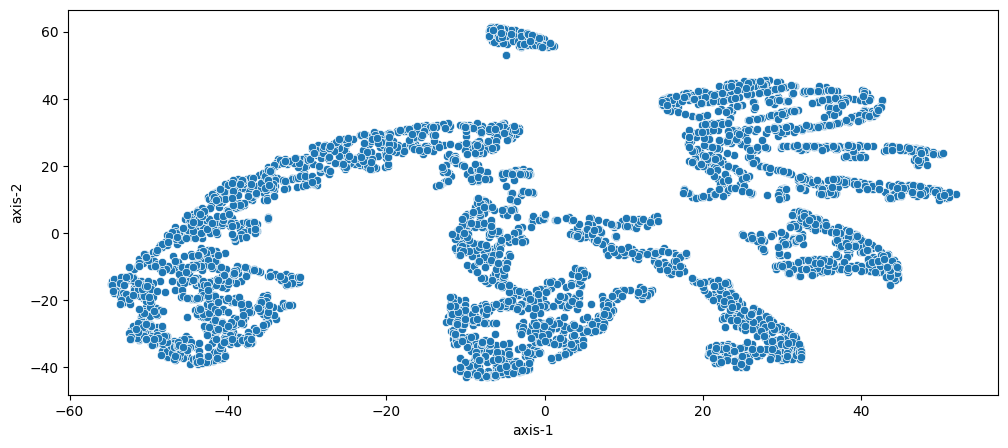

In [128]:
# Преобразуем таблицу обратно в датафрейм
rfm_table_tsne = pd.DataFrame(rfm_table_tsne,
                                   columns=['axis-1', 'axis-2'],
                                   index=rfm_table_cleaned_tsne.index)

# Визуализируем данные
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_tsne, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



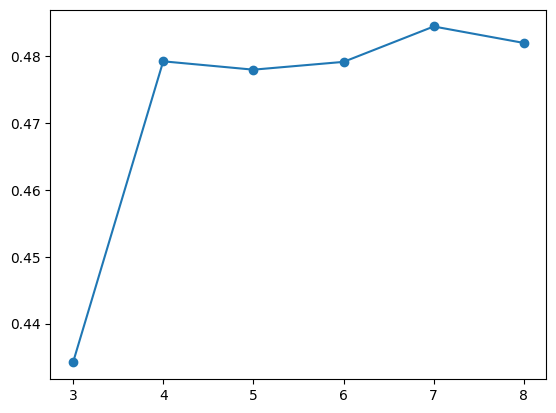

Оптимальное количество кластеров по коэффициенту силуэта: 7
Максимальное значение коэффициента силуэта равно: 0.48


In [129]:
# Создаем список для фиксации значений коэффициента силуэта
silhouette_tsne = []

# В цмкле перебираем значения количества кластеров, обучаем модель и 
# заносим в список полученное значение коэффициента силуэта
for clust_num in range(3, 9):
    k_means_tsne = cluster.KMeans(n_clusters=clust_num, random_state=42)
    k_means_tsne.fit(rfm_table_tsne)
    silhouette_tsne.append(metrics.silhouette_score(rfm_table_tsne, k_means_tsne.labels_))

# Визуализируем результат
plt.plot([i for i in range(3, 9)], silhouette_tsne, marker='o')
plt.show()

# Выводим оптимальное число кластеров и максимальное значение коэффициента силуэта
print(f'Оптимальное количество кластеров по коэффициенту силуэта: '
      f'{[i for i in range(3, 9)][silhouette_tsne.index(max(silhouette_tsne))]}')
print('Максимальное значение коэффициента силуэта равно: {:.2f}'.format(max(silhouette_tsne)))

### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

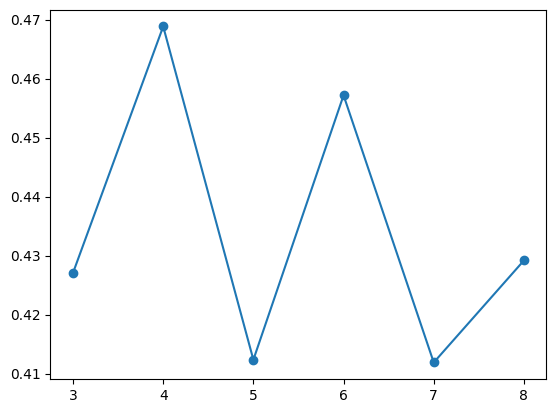

Оптимальное количество кластеров по коэффициенту силуэта: 4
Максимальное значение коэффициента силуэта равно: 0.47


In [130]:
# Создаем список для фиксации значений коэффициента силуэта
silhouette_em = []

# В цмкле перебираем значения количества кластеров, обучаем модель и 
# заносим в список полученное значение коэффициента силуэта
for clust_num in range(3, 9):
    em = mixture.GaussianMixture(n_components=clust_num, random_state=42)
    em.fit(rfm_table_tsne)
    silhouette_em.append(metrics.silhouette_score(rfm_table_tsne, em.predict(rfm_table_tsne)))

# Визуализируем результат
plt.plot([i for i in range(3, 9)], silhouette_em, marker='o')
plt.show()

# Выводим оптимальное число кластеров и максимальное значение коэффициента силуэта
print(f'Оптимальное количество кластеров по коэффициенту силуэта: '
      f'{[i for i in range(3, 9)][silhouette_em.index(max(silhouette_em))]}')
print('Максимальное значение коэффициента силуэта равно: {:.2f}'.format(silhouette_em[1]))

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



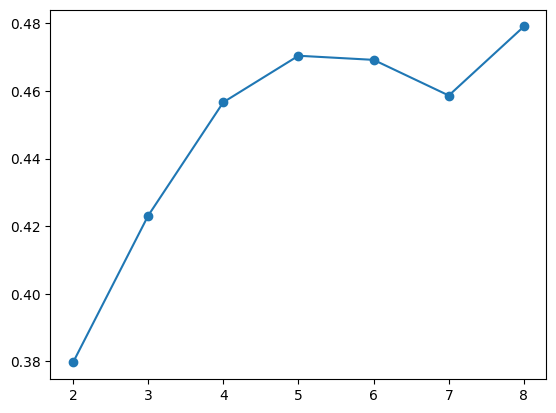

Оптимальное количество кластеров по коэффициенту силуэта: 8
Максимальное значение коэффициента силуэта равно: 0.48


In [131]:
# Создаем список для фиксации значений коэффициента силуэта
silhouette_aglo = []

# В цмкле перебираем значения количества кластеров, обучаем модель и 
# заносим в список полученное значение коэффициента силуэта
for clust_num in range(2, 9):
    aglo = cluster.AgglomerativeClustering(n_clusters=clust_num)
    aglo.fit(rfm_table_tsne)
    silhouette_aglo.append(metrics.silhouette_score(rfm_table_tsne, aglo.labels_))

# Визуализируем результат
plt.plot([i for i in range(2, 9)], silhouette_aglo, marker='o')
plt.show()

# Выводим оптимальное число кластеров и максимальное значение коэффициента силуэта
print(f'Оптимальное количество кластеров по коэффициенту силуэта: '
      f'{[i for i in range(2, 9)][silhouette_aglo.index(max(silhouette_aglo))]}')
print('Максимальное значение коэффициента силуэта равно: {:.2f}'.format(max(silhouette_aglo)))

### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [132]:
# Максимальный коэффициент силуэта (при округлении значений до 3 знаков после запятой) 
# показывает модель K-Means с 7 кластерами - 0.484. Обучим эту модель
k_means = cluster.KMeans(n_clusters=7, random_state=42)
k_means.fit(rfm_table_tsne)

# Создаем признак с метками кластеров 
rfm_table_cleaned_tsne['labels'] = k_means.labels_

#  Выводим максимальное количество клиентов в кластере
print(f"Максимальное количество клиентов в кластере: "
      f"{rfm_table_cleaned_tsne['labels'].value_counts(ascending=False).max()}")


Максимальное количество клиентов в кластере: 914


Визуализируем результаты кластеризации:

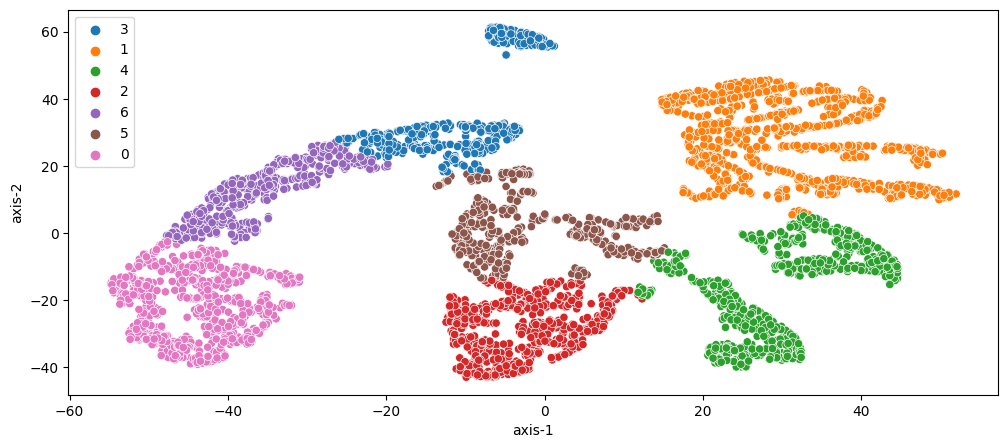

In [133]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_tsne, x='axis-1', y='axis-2', hue=k_means.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [134]:
# Группируем данные по меткам кластеров и ищем среднее значение всех признаков для каждого кластера
grouped = rfm_table_cleaned_tsne.groupby(by='labels')[['Recency', 'Frequency', 'Monetary Value']].mean()

# Выводим максимальное среднее значение признака Recency  
print(f"Максимальное среднее значение признака Recency: {round(grouped['Recency'].max())} дней")

Максимальное среднее значение признака Recency: 313 дней


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [135]:
# Строим полярную диаграмму для наших кластеров
plot_cluster_profile(grouped_data=grouped, n_clusters=7)

### *Выводы*

* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 4 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 2 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер 5 соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер 0 соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер 6 соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер 3 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [136]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned_tsne.drop(labels='labels', axis=1) #очищенная RFM-таблица
y = rfm_table_cleaned_tsne['labels'] #метки кластеров, предсказанные ранее

# Создаем тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.2,
                                                                    random_state=42
                                                                    )

# Вывдим количество клиентов в тестовой выборке
print(f'В тестовую выборку попало {X_test.shape[0]} клиентов')

В тестовую выборку попало 809 клиентов


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [137]:
# Задаем сетку параметров
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# Создаем объект класса GridSearchCV для модели случайного леса
grid_search = model_selection.GridSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42),
                                           scoring='accuracy',
                                           cv=5,
                                           param_grid=param_grid,
                                           n_jobs=-1
                                           )

# Производи подбор оптимальных параметров
grid_search.fit(X=X_train, y=y_train)

# Выводим оптимальное значение глубины деревьев в модели
print(f'Оптимальное значение глубины деревьев: {grid_search.best_params_["max_depth"]}')

# Выводим значение метрики accuracyна тестовой выборке
print(f'Значение accuracy на тестовой выборке: {round(grid_search.score(X=X_test, y=y_test),3)}')

Оптимальное значение глубины деревьев: 13
Значение accuracy на тестовой выборке: 0.985


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.

In [138]:
# Задаем сетку параметров
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

# Создаем объект класса GridSearchCV для модели градиентного бустинга
grid_search_gb = model_selection.GridSearchCV(estimator=ensemble.GradientBoostingClassifier(random_state=42),
                                           scoring='accuracy',
                                           cv=5,
                                           param_grid=param_grid,
                                           n_jobs=-1
                                           )

# Производи подбор оптимальных параметров
grid_search_gb.fit(X=X_train, y=y_train)

# Выводим оптимальное значение глубины деревьев в модели
print(f'Оптимальное значение глубины деревьев: {grid_search_gb.best_params_["max_depth"]}')

# Выводим значение метрики accuracyна тестовой выборке
print(f'Значение accuracy на тестовой выборке: {round(grid_search_gb.score(X=X_test, y=y_test),3)}')

Оптимальное значение глубины деревьев: 4
Значение accuracy на тестовой выборке: 0.983


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

В заключение отметим, что сегментация клиентов не ограничивается только RFM-анализом. Что ещё можно сделать?

Выделить оптовиков в отдельный сегмент. В таком случае идея метода RFM расширяется путём добавления в датасет информации о среднем количестве покупаемого товара за один заказ. То есть аббревиатура RFM превращается в RFMQ, где Q — среднее количество товаров в одном заказе.
Произвести кластерный анализ товаров на основе их описания и сформировать категории, по которым совершаются покупки.
Рассчитать частоту покупки каждой категории товаров для каждого клиента. Эта информация может стать основой для построения модели кластеризации и сегментирования клиентов по их интересам.
Наконец, воспользоваться информацией о сезонности покупок и добавить в модель информацию о частоте покупок клиентов в каждый из месяцев. Так можно определить, какие клиенты являются постоянными, то есть их покупки не зависят от сезона, а какие покупают товары только в преддверии праздников. Эта информация позволит экспериментировать с маркетинговой кампанией и повышать лояльность клиентов.